# Run Metaneighbor
Salomé Carcy, 02 September 2024

## 1. IMPORT
### 1.1. Import librairies
All the information to download the pyMN (pymetaneighbor) package can be found here: https://github.com/gillislab/pyMN

In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import pymn

Set working directory.

In [2]:
import os
os.chdir("/Users/scarcy/Projects/HumanThymusProject/")
os.getcwd()

'/Users/scarcy/Projects/HumanThymusProject'

### 1.2. Import data

In [3]:
adata = sc.read_h5ad('./data_github/park_dataset/pymtn/human_thym_merged_with_park_240902.h5ad')
print(adata)

AnnData object with n_obs × n_vars = 114363 × 13888
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount', 'nFeature', 'clusters_to_compare', 'study'
    var: 'features'


In [4]:
# highly variable genes
hvg = pd.read_csv(r'./data_github/park_dataset/pymtn/human_thym_merged_with_park_list_hvg_240902.csv', index_col=0)
hvg.head()

,features,highly_variable
1,A1BG,False
2,A1CF,False
3,A2M,True
4,A2ML1,False
5,A4GALT,False


## 2. RUN METANEIGHBOR
### 2.1. Prepare data

In [5]:
# Make sure observation columns of interest are strings
adata.obs['study'] = adata.obs['study'].astype(str)
adata.obs['clusters_to_compare'] = adata.obs['clusters_to_compare'].astype(str)
print(adata.obs.head())

                     orig.ident  nCount_RNA  nFeature_RNA  nCount  nFeature  \
CD4_1_Thymus_878524           0      8453.0          2808  8736.0      2936   
CD4_1_Thymus_679405           0      7695.0          2786  7993.0      2906   
CD4_1_Thymus_281188           0      8128.0          2832  8440.0      2959   
CD4_1_Thymus_285601           0      7607.0          2852  7926.0      2982   
CD4_1_Thymus_174537           0      7898.0          2841  8149.0      2979   

                    clusters_to_compare       study  
CD4_1_Thymus_878524                  c1  gapin_data  
CD4_1_Thymus_679405                  c1  gapin_data  
CD4_1_Thymus_281188                  c1  gapin_data  
CD4_1_Thymus_285601                  c7  gapin_data  
CD4_1_Thymus_174537                  c1  gapin_data  


In [6]:
# add HVGs to anndata object
adata.var = pd.merge(adata.var, hvg, on=['features'], how='inner')
adata.var.index.name = 'features'
adata.var.index = adata.var.index.astype(str) # overcome error message
print(adata.var.head())
print(adata.var.highly_variable.value_counts()) # should have 3104 HVGs

         features  highly_variable
features                          
0            A1BG            False
1            A1CF            False
2             A2M             True
3           A2ML1            False
4          A4GALT            False
False    10784
True      3104
Name: highly_variable, dtype: int64


/Users/scarcy/opt/anaconda3/envs/humanthymusproj/lib/python3.11/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [7]:
# subset anndata object to only HVGs
adatasub = adata[:,adata.var['highly_variable']]
print(adatasub) # 3104 features

View of AnnData object with n_obs × n_vars = 114363 × 3104
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount', 'nFeature', 'clusters_to_compare', 'study'
    var: 'features', 'highly_variable'


### 2.2. Run MetaNeighbor
On your local computer, you may not be able to run the slow version of MetaNeighbor. To reproduce Supplementary Fig 4B, we recommend to run the [pymtn_park_02_run_metaneighbor.py](./pymtn_park_02_run_metaneighbor.py) script on a high-performance cluster. Otherwise, you can also run a fast version of metaneighbor (hereafter) on your local computer, and you will obtain results very similar to Supplementary Fig 4B (with minor changes in some AUROC scores).

In [8]:
pymn.MetaNeighborUS(
    adatasub,
    study_col='study',
    ct_col='clusters_to_compare',
    fast_version=True
)

/Users/scarcy/opt/anaconda3/envs/humanthymusproj/lib/python3.11/site-packages/pymn/MetaNeighborUS.py:130: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[mn_key] = cell_nv


### 2.3. Quick look at output

In [9]:
print(adatasub.uns['MetaNeighborUS'].head())

                gapin_data|c0  gapin_data|c1  gapin_data|c10  gapin_data|c11  \
gapin_data|c0        0.996773       0.925217        0.207547        0.165770   
gapin_data|c1        0.925217       0.985977        0.251756        0.156210   
gapin_data|c10       0.207547       0.251756        0.960106        0.732188   
gapin_data|c11       0.165770       0.156210        0.732188        0.911133   
gapin_data|c12       0.204638       0.184267        0.662464        0.821279   

                gapin_data|c12  gapin_data|c13  gapin_data|c14  \
gapin_data|c0         0.204638        0.229833        0.244785   
gapin_data|c1         0.184267        0.179157        0.251502   
gapin_data|c10        0.662464        0.673649        0.674775   
gapin_data|c11        0.821279        0.714792        0.662880   
gapin_data|c12        0.977903        0.958054        0.967076   

                gapin_data|c15  gapin_data|c16  gapin_data|c17  ...  \
gapin_data|c0         0.303103        0.233300     

/Users/scarcy/opt/anaconda3/envs/humanthymusproj/lib/python3.11/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


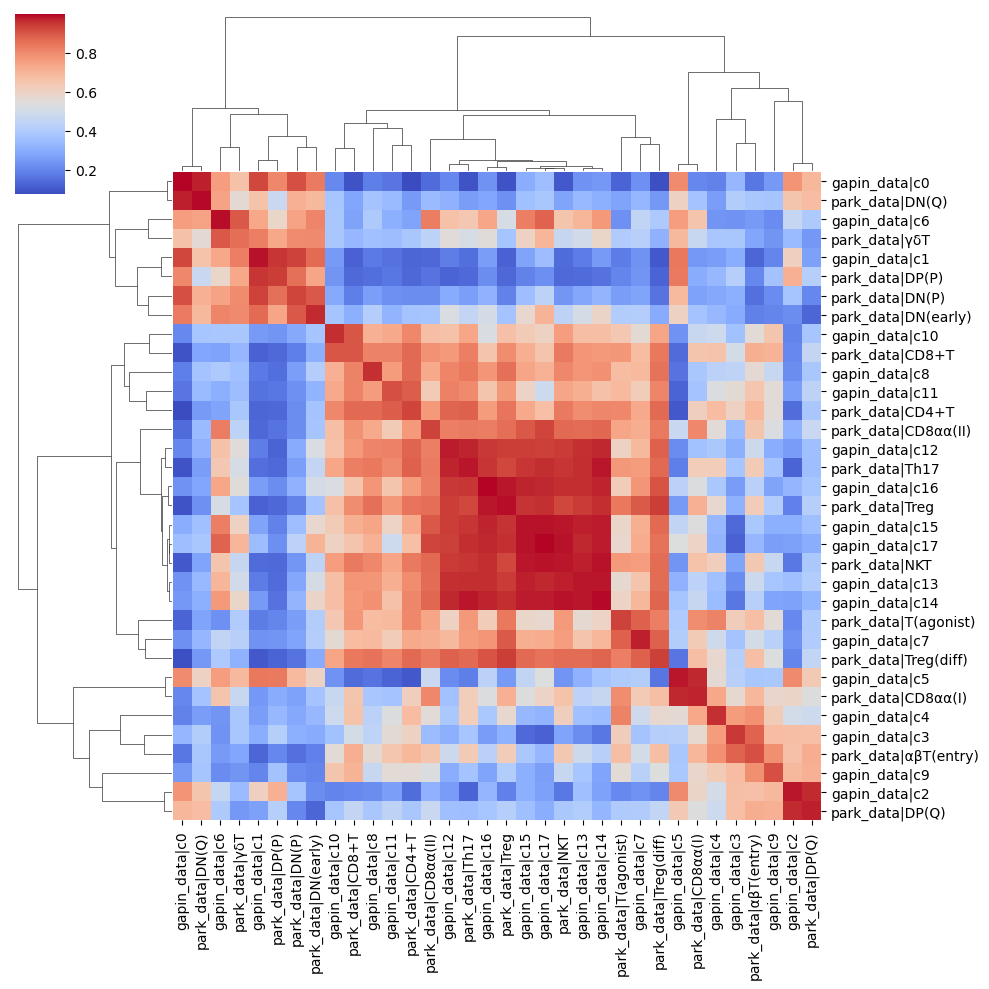

In [10]:
pymn.plotMetaNeighborUS(adatasub, figsize=(10, 10), cmap='coolwarm', fontsize=10)

### 2.4. Save output

In [11]:
adatasub.uns['MetaNeighborUS'].to_csv("./data_github/park_dataset/pymtn/human_thym_merged_with_park_pymtn_fast_version_output_240902.csv")